In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import script.helperfuncs as hf        # Follow docstrings and look at helperfuncs.py beforehand
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('data/pbp-2020.csv')

In [3]:
# Clean Data
df.drop(['Unnamed: 10', 'Unnamed: 12', 'Unnamed: 16', 'Unnamed: 17', 'Challenger', 'IsMeasurement'], axis=1, inplace=True) # Removing empty columns
df.sort_values(['GameId', 'Quarter', 'Minute', 'Second'], ascending=[True, True, False, False], inplace=True)              #Sorted by game and ordered by game time
df = df[df['PlayType'].notnull()]                                     # Removed null values associated with procedural warnings ie Two-Minute Warnings
df = df[df['PlayType']!='TIMEOUT']                                    # Removed timeouts
df = df[df['IsNoPlay']==0]                                            # Removed plays where the result of the play was called back
df['IsSuccess'] = df.apply(lambda row: hf.is_success(row), axis=1)       # Added a column indicating whether or not the play was a success


In [4]:
# Useful Variables
rush_plays = df[df['IsRush']==1]                                        # Grouped dataframe of rush plays
pass_plays = df[df['IsPass']==1]                                        # Grouped dataframe of pass plays
Is_list = ['IsRush', 'IsPass', 'IsIncomplete', 'IsTouchdown', 'IsSack', 'IsChallenge', 'IsChallengeReversed', 'IsInterception',
    'IsFumble', 'IsPenalty', 'IsTwoPointConversion', 'IsTwoPointConversionSuccessful', 'IsPenaltyAccepted', 'IsNoPlay', 'IsSuccess']
formations = ['UNDER CENTER', 'SHOTGUN', 'NO HUDDLE SHOTGUN', 'NO HUDDLE']

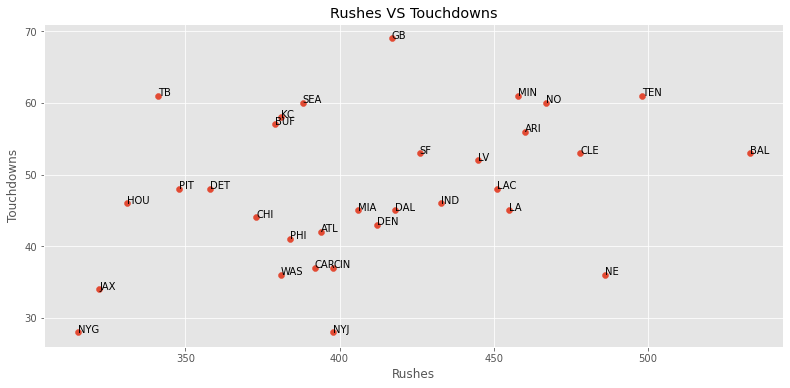

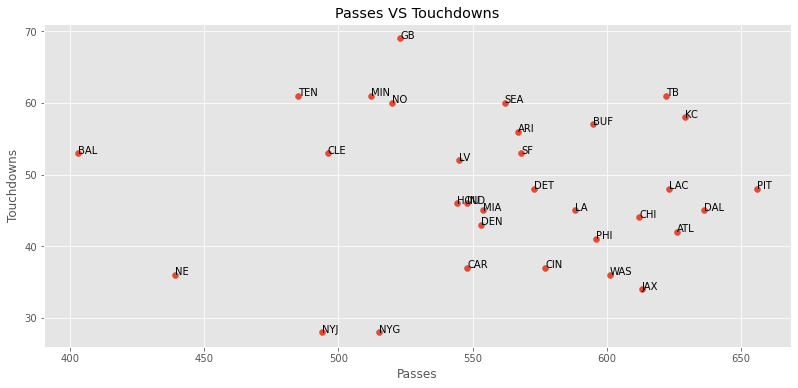

In [5]:
# Initial Plotting Exploration
# Let's see how run plays and pass plays look plotted against touchdowns
hf.compare_team_is_stats('IsRush','IsTouchdown')
hf.compare_team_is_stats('IsPass','IsTouchdown')

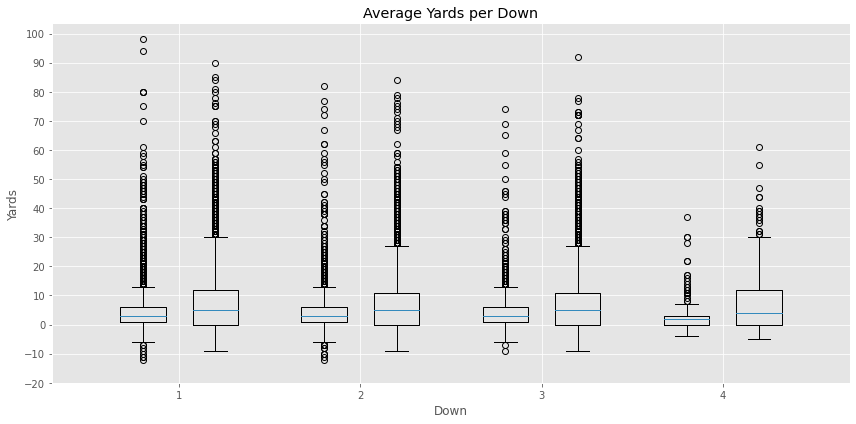

In [6]:
# Quick look at yards gained per rush and pass attempt. Run plays are on the left and passing plays are on the right.
# The distribution of run and pass plays looks about the same for downs 1-3, but on fourth down run plays get less yards.
# This graph shows independence for downs 1-3 and that on fourth down runs are only designed to get you one or two yards.
hf.league_box()

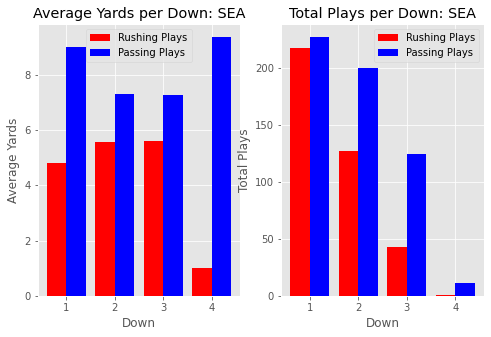

In [7]:
# I am a Seahawks fan, so let's look at their 2020 season for a bit
hf.avg_yards_by_down('SEA')
# It looks like the "Let Russ Cook" campaign had a real influence this year

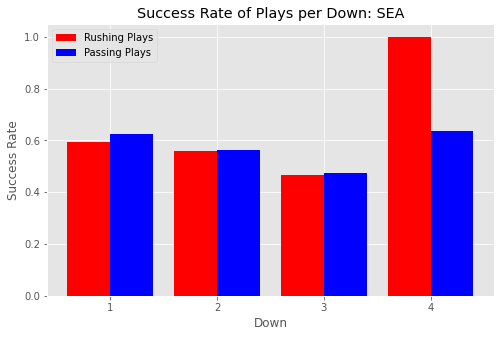

In [8]:
# Instead of using the traditional avg yards per play metric to judge success, let's use the new one. Success on 1st down is measured by getting 40% to the first down marker, 60% on second down, and on third and fourth you need to convert for a first down for it to be a success.
hf.success_rate_by_down('SEA')
# In terms of which plays worked and which didn't, Seattle looks like a much more balanced team than initially observed.

No handles with labels found to put in legend.


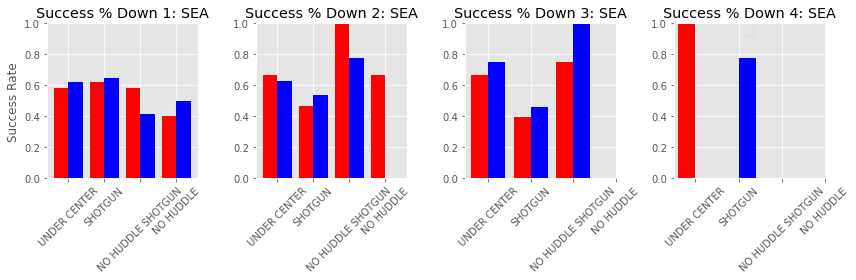

In [9]:
# We can break this success metric down even further to look at success rates for specific offensive formations as well
hf.success_rate_by_down_and_formation('SEA')
# In the future, I would like to go even further and break down run success by run direction and passing success by receiver.

/home/kellen/Documents/DSI_Galvanize/Capstones/Capstone-1-Repository/helperfuncs.py:222: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


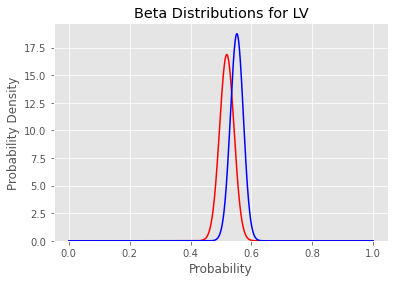

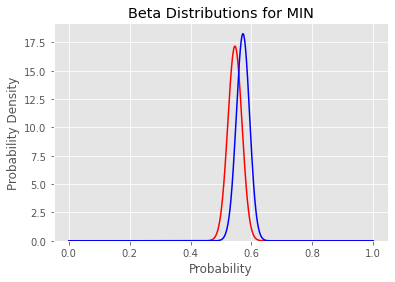

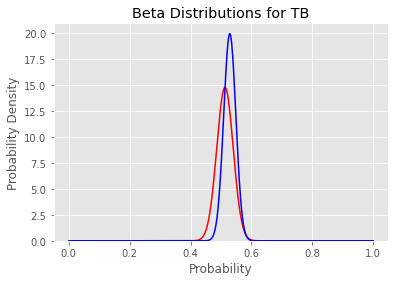

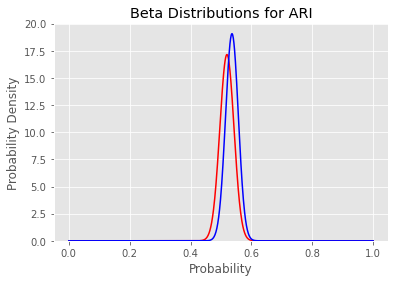

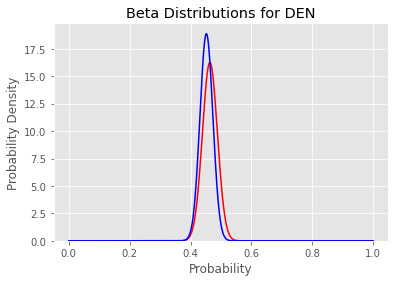

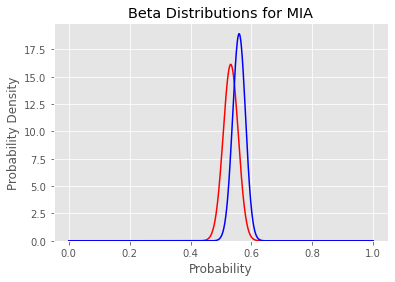

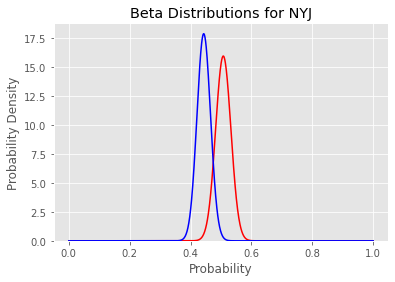

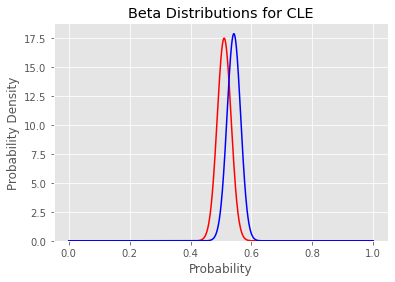

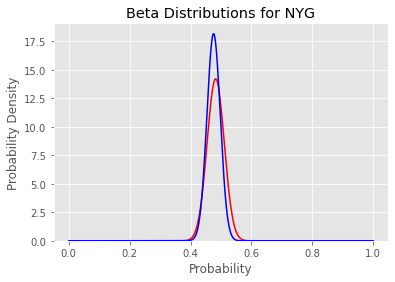

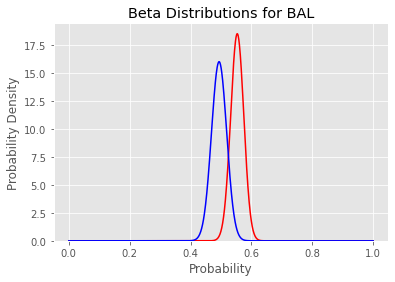

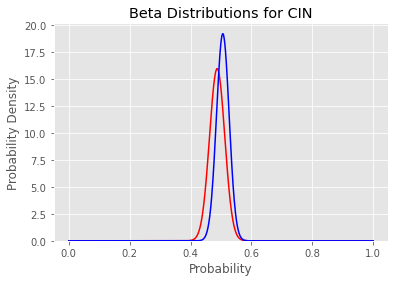

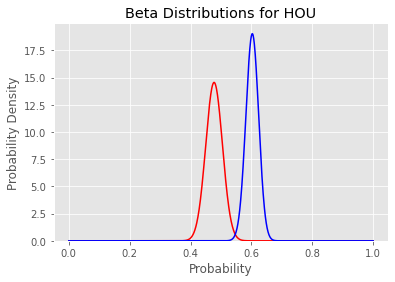

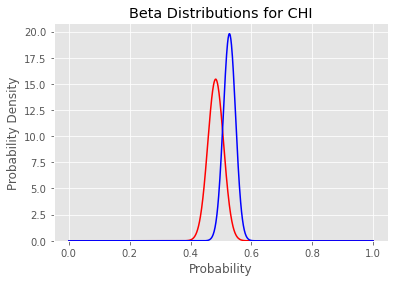

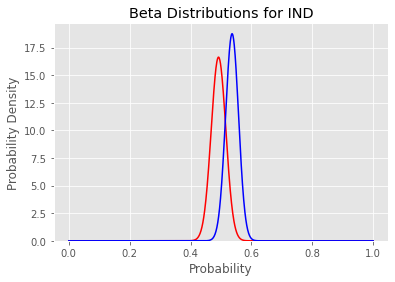

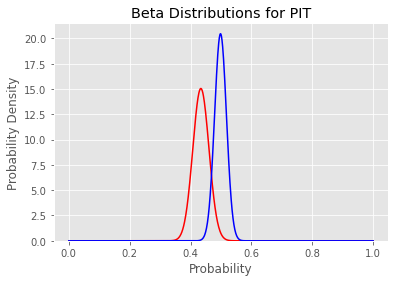

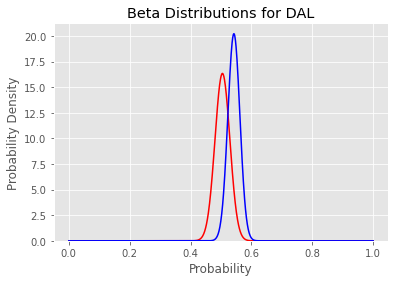

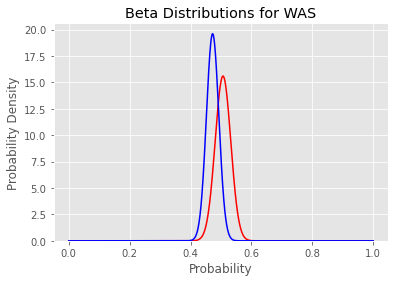

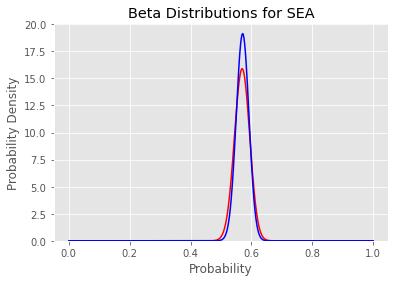

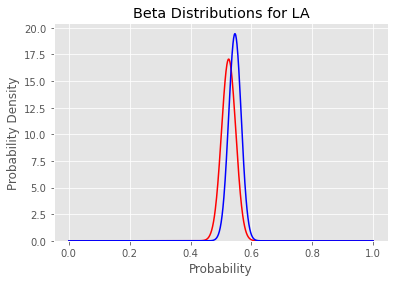

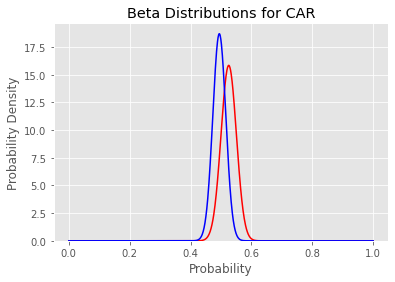

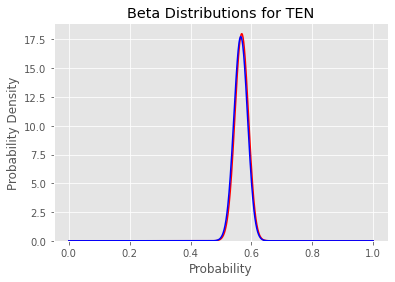

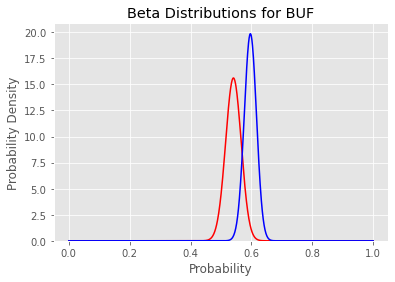

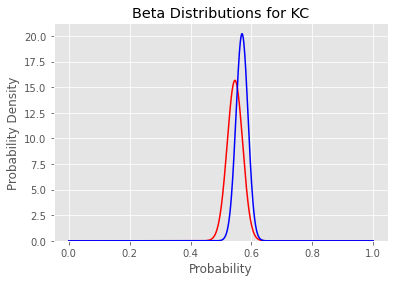

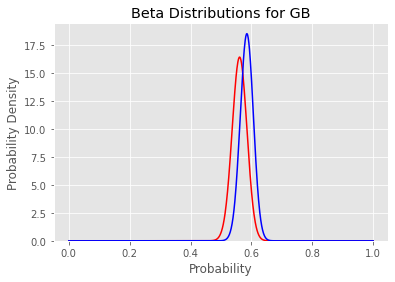

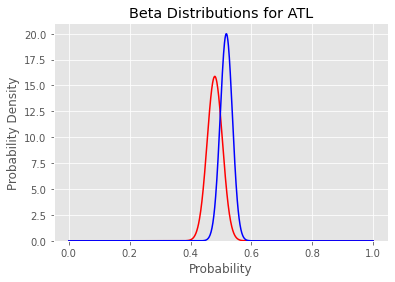

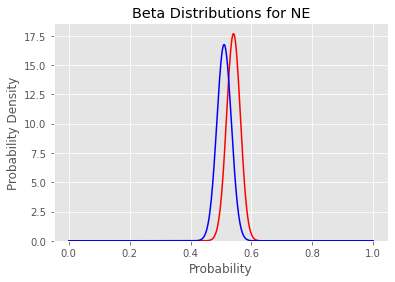

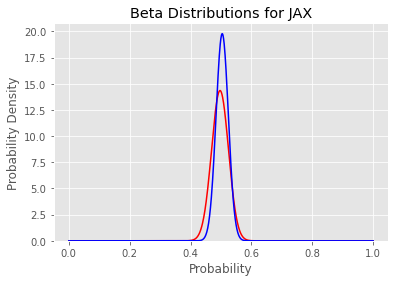

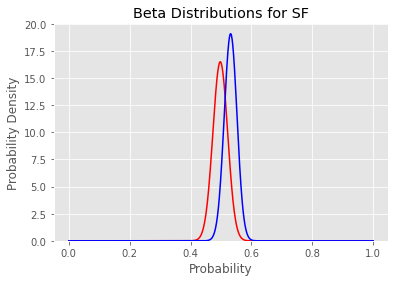

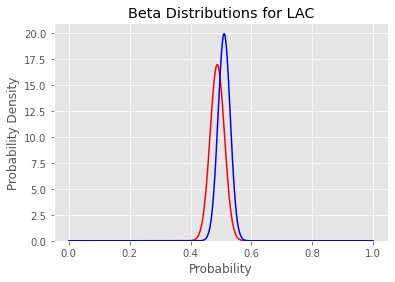

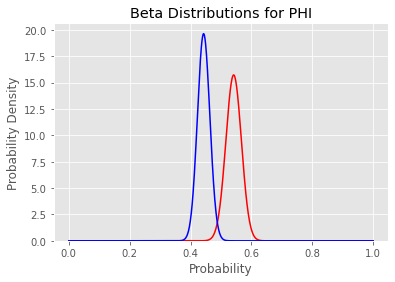

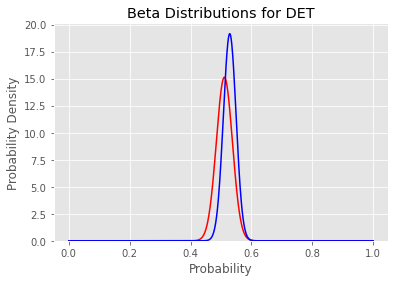

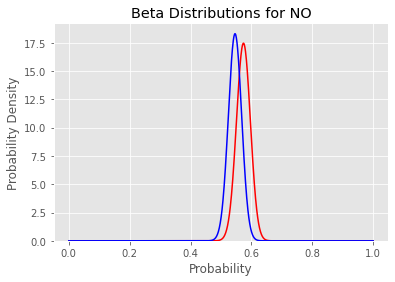

In [10]:
# Zooming out to look at the league as a whole, we can get a good snapshot of what each team's general offsensive scheme by comparing beta distribution graphs
for team in hf.teams:
    hf.graph_beta_dist(team)
# There are 32 graphs here, but look through and find your team to see how they stack up against offensive juggernauts like KC!
# Interestingly, NE, TEN, and BAL are the only teams who rush more than they pass.

Text(0.5, 1.0, 'NFL Rush and Pass Probability Densities')

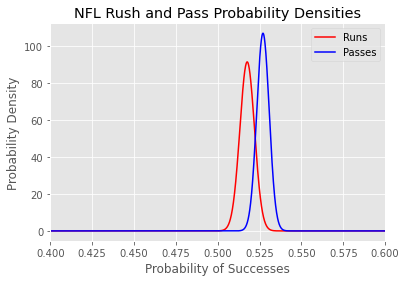

In [11]:
# Here is the league wide beta distribution if you don't want to compare your team to KC anymore. I certainly don't.
runs = hf.get_beta_dist_league()[0]
passes = hf.get_beta_dist_league()[1]
x=np.linspace(0,1,10000)
plt.plot(x, runs.pdf(x), color = 'red', label='Runs')
plt.plot(x, passes.pdf(x), color='blue', label='Passes')
plt.xlim(.4,.6)
plt.legend()
plt.xlabel('Probability of Successes')
plt.ylabel('Probability Density')
plt.title('NFL Rush and Pass Probability Densities')
# Both rushing and passing plays have an above 50% success rate for the league as a whole.

In [12]:
# Here are the Baysian probabilities that for each team a pass play will be more successful than a run play
result = {}
for team in hf.teams:
    result[team] = hf.get_beta_dist(team)[2]
print({k:v for k,v in sorted(result.items(), key=lambda item: item[1], reverse=True)})
# For most teams, passing plays look more successful than run plays to a degree. Most of the teams below .5 here had bad seasons with the exceptions of TEN, NO, and BAL.

{'HOU': 0.99986, 'PIT': 0.97257, 'BUF': 0.95727, 'CHI': 0.91703, 'IND': 0.91625, 'DAL': 0.88468, 'ATL': 0.8807, 'SF': 0.85658, 'LV': 0.85151, 'CLE': 0.83873, 'MIA': 0.8008, 'MIN': 0.7962, 'GB': 0.76928, 'LAC': 0.76907, 'KC': 0.76512, 'LA': 0.7435, 'CIN': 0.715, 'DET': 0.70058, 'ARI': 0.70048, 'TB': 0.68086, 'JAX': 0.58253, 'SEA': 0.52235, 'TEN': 0.45864, 'NYG': 0.42254, 'DEN': 0.36374, 'NO': 0.1901, 'CAR': 0.17592, 'NE': 0.17318, 'WAS': 0.15143, 'BAL': 0.03552, 'NYJ': 0.02855, 'PHI': 0.00121}


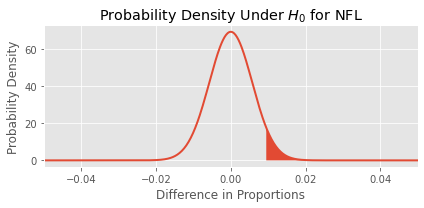

In [13]:
# From a frequentist perspective, we can conduct two sample ttests under the H_0: The rate of success for run plays is less than or equal to the rate of success for pass plays. We can use this test because the variance of both will be around .25 and we are assuming the two distributions are independent. Let's set our alpha level at .02 so we can be more certain when telling the coaches. The shaded region represents our P-Value of .1002.
# In this case, we fail to reject the null hypothesis
hf.graph_confidence_interval()

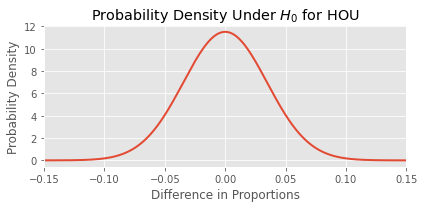

In [14]:
# After the Bonferroni correction for 33 tests, one for each team and one for the league as a whole, our new alpha is .00061! With the same H_0, there was only one team whose P-Value of .00028 cleared the alpha threshold. Behold the imbalanced Houston Texans. The shaded region is almost invisible here.
hf.graph_confidence_interval_team('HOU')

In [15]:
# Here are the P-Values for each team under the same H_0
p_vals = {}
for team in hf.teams:
    p_vals[team] = hf.get_pval(team)
print({k:v for k,v in sorted(p_vals.items(), key=lambda item: item[1])})


{'HOU': 0.00027861707653005995, 'PHI': 0.0025087460262895444, 'PIT': 0.05130911793301274, 'NYJ': 0.05625011984654407, 'BAL': 0.07030283968425638, 'BUF': 0.08638223638716307, 'IND': 0.1656429969467502, 'CHI': 0.1689619976668997, 'DAL': 0.23120198777201104, 'ATL': 0.23921659891023028, 'SF': 0.2883683507454097, 'LV': 0.29791331881277927, 'WAS': 0.29915713455993376, 'CLE': 0.31967834719949273, 'NE': 0.3477834458172939, 'CAR': 0.34933802240851386, 'NO': 0.3816242424377423, 'MIA': 0.39740490181816523, 'MIN': 0.40857562762102195, 'GB': 0.4614259556693382, 'LAC': 0.4646273761206082, 'KC': 0.47152334530284334, 'LA': 0.5077543583656219, 'CIN': 0.567924849407917, 'ARI': 0.5967852957431283, 'DET': 0.6009636748427679, 'TB': 0.6403621956799153, 'DEN': 0.7228415320665581, 'JAX': 0.8348527759534045, 'NYG': 0.8490348413879415, 'TEN': 0.9163502208723545, 'SEA': 0.9613168278094009}
